Author: Heng-Jui Chang


# **Download Data**


If the Google drive links are dead, you can download data from [kaggle](https://www.kaggle.com/c/ml2021spring-hw1/data), and upload data manually to the workspace.

# **Import Some Packages**

In [86]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

# For data preprocess
import pandas as pd
import numpy as np
import csv
import os

from tqdm import tqdm

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

myseed = 80215  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

# **Some Utilities**

You do not need to modify this part.

In [2]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()


def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()
    


# **Preprocess**

We have three kinds of datasets:
* `train`: for training
* `dev`: for validation
* `test`: for testing (w/o target value)

In [37]:
attri_data = pd.read_csv('../LiterallyWikidata/files_needed/nogeo_a89')

In [10]:
x = attri_data[['e','a']].to_numpy()
y = attri_data['std_v'].to_numpy()

In [ ]:
## constraint needed:
pop_idx = dict_all_2_idx['P1082']
gdp = dict_all_2_idx['P4010']
nominal_gdp = dict_all_2_idx['P2131']
nominal_gdp_per = dict_all_2_idx['P2132']
gdp_per = dict_all_2_idx['P2299']
date_of_birth = dict_all_2_idx['P569']
date_of_death = dict_all_2_idx['P570']
area = ['P2046']
# net_profit = dict_all_2_idx['P2295']
# retirement_age = dict_all_2_idx['P3001']
# age_of_majority = dict_all_2_idx['P2997']
# work_start = dict_all_2_idx['P2031']
# work_end = dict_all_2_idx['P2032']

In [40]:
## Load pretrain embedding
emb_ent = torch.load('../LiterallyWikidata/files_needed/pretrained_kge/pretrained_complex_entemb.pt')
list_ent_ids =[]
with open('../LiterallyWikidata/files_needed/list_ent_ids.txt','r') as f:
    for line in f:
        list_ent_ids.append(line.strip())
## Preparing ent embedding
ent2idx = {e:i for i,e in enumerate(list_ent_ids)}
attri_data['ent_idx']= attri_data['e'].map(ent2idx)
embedding_e = torch.nn.Embedding.from_pretrained(emb_ent)
input_e = torch.LongTensor(attri_data['ent_idx'].to_numpy())

entity_embedding = embedding_e(input_e)
## Preparing att embedding
att2idx = {a:i for i,a in enumerate(attri_data['a'].unique())}
attri_data['a_idx']=attri_data['a'].map(att2idx)
embedding_a = torch.nn.Embedding(len(attri_data['a'].unique()),128,padding_idx=0)
input_a = torch.LongTensor(attri_data['a_idx'].to_numpy())

attribute_embedding = embedding_a(input_a)
## concat two embedding
x_data = torch.cat([entity_embedding,attribute_embedding],dim=1).detach().numpy()

y= attri_data.loc[:,'std_v'].to_numpy()

In [45]:
from sklearn.model_selection import train_test_split
X_trainset, X_testset, y_trainset, y_testset = train_test_split(x_data, y,test_size=0.2, random_state=802)

In [62]:
x_data.shape

(180015, 256)

## **Dataset**


In [51]:
class KGMTL_Data(Dataset):
    '''
    x: Features.
    y: Targets, if none, do prediction.
    '''
    def __init__(self, x, y=None):
        if y is None:
            self.y = y
        else:
            self.y = torch.FloatTensor(y)
        self.x = torch.FloatTensor(x)
        

    def __getitem__(self, idx):
        if self.y is None:
            return self.x[idx]
        else:
            return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)


    

## **DataLoader**

A `DataLoader` loads data from a given `Dataset` into batches.


In [52]:
train_set =KGMTL_Data(X_trainset,y_trainset)
valid_set =KGMTL_Data(X_testset,y_testset)
train_loader = DataLoader(train_set, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=config['batch_size'], shuffle=True, pin_memory=True)


# **Deep Neural Network**

`NeuralNet` is an `nn.Module` designed for regression.
The DNN consists of 2 fully-connected layers with ReLU activation.
This module also included a function `cal_loss` for calculating loss.


In [75]:
class NeuralNet(nn.Module):
    ''' A simple fully-connected deep neural network '''
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()

        # Define your neural network here
        # TODO: How to modify this model to achieve better performance?
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

        # Mean squared error loss
        self.criterion = nn.MSELoss(reduction='mean')

    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x).squeeze(1)

    def cal_loss(self, pred, target):
        ''' Calculate loss '''
        # TODO: you may implement L1/L2 regularization here
        return torch.sqrt(self.criterion(pred, target))

# **Train/Dev/Test**

## **Training**

In [83]:
def train(tr_set, dv_set, model, config, device):
    ''' DNN training '''

    n_epochs = config['n_epochs']  # Maximum number of epochs

    # Setup optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=config['learning_rate'], momentum=0.9, weight_decay=1e-6) 

    min_mse = 10.**20
    loss_record = {'train': [], 'dev': []}      # for recording training loss
    early_stop_cnt = 0
    epoch = 0

    
    for epoch in range(n_epochs):
        model.train() 
        
        # tqdm is a package to visualize your training progress.
        train_pbar = tqdm(train_loader, position=0, leave=True)
        
        # set model to training mode
        for x, y in train_pbar:                     # iterate through the dataloader
            optimizer.zero_grad()               # set gradient to zero
            x, y = x.to(device), y.to(device)   # move data to device (cpu/cuda)
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
            mse_loss.backward()                 # compute gradient (backpropagation)
            optimizer.step()                    # update model with optimizer
            loss_record['train'].append(mse_loss.detach().cpu().item())

        # After each epoch, test your model on the validation (development) set.
        dev_mse = dev(dv_set, model, device)
        if dev_mse < min_mse:
            # Save model if your model improved
            min_mse = dev_mse
            print('Saving model (epoch = {:4d}, loss = {:.4f})'
                .format(epoch + 1, min_mse))
            torch.save(model.state_dict(), config['save_path'])  # Save model to specified path
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1

        epoch += 1
        loss_record['dev'].append(dev_mse)
        if early_stop_cnt > config['early_stop']:
            # Stop training if your model stops improving for "config['early_stop']" epochs.
            break

    print('Finished training after {} epochs'.format(epoch))
    return min_mse, loss_record

## **Validation**

In [55]:
def dev(dv_set, model, device):
    model.eval()                                # set model to evalutation mode
    total_loss = 0
    for x, y in dv_set:                         # iterate through the dataloader
        x, y = x.to(device), y.to(device)       # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
        total_loss += mse_loss.detach().cpu().item() * len(x)  # accumulate loss
    total_loss = total_loss / len(dv_set.dataset)              # compute averaged loss

    return total_loss

## **Testing**

In [56]:
def test(tt_set, model, device):
    model.eval()                                # set model to evalutation mode
    preds = []
    for x in tt_set:                            # iterate through the dataloader
        x = x.to(device)                        # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            preds.append(pred.detach().cpu())   # collect prediction
    preds = torch.cat(preds, dim=0).numpy()     # concatenate all predictions and convert to a numpy array
    return preds

# **Setup Hyper-parameters**

`config` contains hyper-parameters for training and the path to save your model.

In [80]:
device = get_device()                 # get the current available device ('cpu' or 'cuda')
os.makedirs('models', exist_ok=True)  # The trained model will be saved to ./models/
target_only = False                   # TODO: Using 40 states & 2 tested_positive features

# TODO: How to tune these hyper-parameters to improve your model's performance?
config = {
    'n_epochs': 3000,                # maximum number of epochs
    'batch_size': 500,               # mini-batch size for dataloader
    'learning_rate':0.001,
    'early_stop': 2000,               # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/model.pth' , # your model will be saved here
    'valid_ratio': 0.1,   # validation_size = train_size * valid_ratio
}


# **Load data and model**

In [84]:
model = NeuralNet(256).to(device)  # Construct model and move to device

# **Start Training!**

In [ ]:
model_loss, model_loss_record = train(train_loader, valid_loader, model, config, device)

100%|█████████████████████████████████████████| 534/534 [00:01<00:00, 302.77it/s]


Saving model (epoch =    1, loss = 21715759932360.0469)


100%|█████████████████████████████████████████| 534/534 [00:01<00:00, 320.15it/s]


Saving model (epoch =    5, loss = 21715759932345.0742)


100%|█████████████████████████████████████████| 534/534 [00:01<00:00, 353.48it/s]


Saving model (epoch =   12, loss = 21715759932331.1602)


100%|█████████████████████████████████████████| 534/534 [00:01<00:00, 372.09it/s]


Saving model (epoch =   13, loss = 21715759932130.0820)


100%|█████████████████████████████████████████| 534/534 [00:01<00:00, 370.71it/s]


Saving model (epoch =   14, loss = 21715759932029.7930)


100%|█████████████████████████████████████████| 534/534 [00:01<00:00, 336.40it/s]


Saving model (epoch =   23, loss = 21715759931932.2031)


100%|█████████████████████████████████████████| 534/534 [00:01<00:00, 377.50it/s]


100%|█████████████████████████████████████████| 534/534 [00:01<00:00, 347.09it/s]


100%|█████████████████████████████████████████| 534/534 [00:01<00:00, 367.10it/s]


100%|█████████████████████████████████████████| 534/534 [00:01<00:00, 344.37it/s]


Saving model (epoch =  359, loss = 20682597954686.7812)


100%|█████████████████████████████████████████| 534/534 [00:01<00:00, 345.11it/s]


 52%|█████████████████████▍                   | 279/534 [00:00<00:00, 309.17it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█████████████████████████████████████████| 534/534 [00:01<00:00, 374.51it/s]


 79%|████████████████████████████████▎        | 421/534 [00:01<00:00, 396.37it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█████████████████████████████████████████| 534/534 [00:01<00:00, 370.27it/s]


100%|█████████████████████████████████████████| 534/534 [00:01<00:00, 398.05it/s]


100%|█████████████████████████████████████████| 534/534 [00:01<00:00, 349.72it/s]


100%|█████████████████████████████████████████| 534/534 [00:01<00:00, 311.61it/s]


100%|█████████████████████████████████████████| 534/534 [00:01<00:00, 371.40it/s]


100%|█████████████████████████████████████████| 534/534 [00:01<00:00, 341.06it/s]


100%|█████████████████████████████████████████| 534/534 [00:01<00:00, 340.76it/s]


100%|█████████████████████████████████████████| 534/534 [00:01<00:00, 373.74it/s]


 83%|██████████████████████████████████       | 444/534 [00:01<00:00, 369.09it/s]

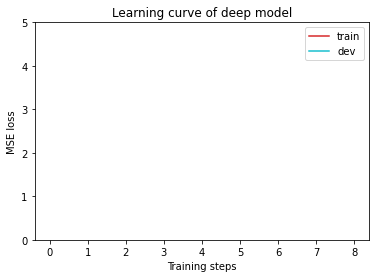

In [73]:
plot_learning_curve(model_loss_record, title='deep model')

In [74]:
model_loss

1e+18

In [ ]:
del model
model = NeuralNet(tr_set.dataset.dim).to(device)
ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)
plot_pred(dv_set, model, device)  # Show prediction on the validation set

# **Testing**
The predictions of your model on testing set will be stored at `pred.csv`.

In [68]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

preds = test(valid_loader, model, device)  # predict COVID-19 cases with your model
print('pred')         # save prediction file to pred.csv

AttributeError: 'list' object has no attribute 'to'

# **Hints**

## **Simple Baseline**
* Run sample code

## **Medium Baseline**
* Feature selection: 40 states + 2 `tested_positive` (`TODO` in dataset)

## **Strong Baseline**
* Feature selection (what other features are useful?)
* DNN architecture (layers? dimension? activation function?)
* Training (mini-batch? optimizer? learning rate?)
* L2 regularization
* There are some mistakes in the sample code, can you find them?

# **Reference**
This code is completely written by Heng-Jui Chang @ NTUEE.  
Copying or reusing this code is required to specify the original author. 

E.g.  
Source: Heng-Jui Chang @ NTUEE (https://github.com/ga642381/ML2021-Spring/blob/main/HW01/HW01.ipynb)
